The goal of this workbook is to try out some PCA to reduce the number of dimensions among our potential predictor variables.

In particular, there are several collections of physical measurements that seem like they might have a latent variable. Perhaps we can use PCA to reduce each category of physical measurement to a small number (1-3) dimensions that will be easier to incorporate into a predictive model

First, I'll try a regular PCA with the physical variables to see if it's possible/meaningful.

Then I'll try it with the FitnessGram variables and the Bio-electric Impedance variables

**Some Big Questions**

* If one variable is dependent on others, should we include it? In this case, we have height, weight, and BMI as variables. BMI is computed from the first two (it's weight divided by the squarae of height). Does this mean if we include all three variables that, in some way, height and weight will be over-weighted because they're sort of being counted twice? Or does the fact that BMI uses the inverse of the square of height mean that we should still include it?
* If two variables are directly related, should we include both of them? In our data we have weight and waist circumference. I'm pretty sure we've explored how/that these are directly proportional. Does that mean we should only use one of them in the PCA? And/or in the model? (Similar question for systolic and diastolic blood pressure.)
* PCA "can only be used with linear data." I'm  wondering what "only be used with linear data" means. "Linear" refers to a relationship between variables. So how would we identify whether or not PCA can be used?

**Some Ideas about Answers**

* The whole point of PCA is reducing the number of variables when they are dependent on each other. If two variables are perfectly correlated, then PCA will reduce them to a single dimension.
* "Can only be used with linear data" means that if two variables have a distinctly non-linear relationship then you either need to transform one of the variables (to make the relationship linear) or use an alternative method - like kernel PCA - that doesn't rely on assumptions of linearity

**More Questions**
* I believe we can do PCA on subsets of the variables and then recombine them to make new predictors that we can use in the final model. How exactly does this process work? I think it works by building a DF with the PCA components and then subbing those into the data
* What benefits and drawbacks are there to selecting the sets on which we do PCA versus trying to use PCA for all of the predictor variables?
* How do we handle missing values?
* Can we impute values? If we do, should we just impute based on the Physical characteristics, or should we impute based on other collections of predictors (assuming some sort of knn imputation)
* We need to look at the distribution of age among the NaN values. What do we do if some ages are more likely to be missing values
* How non-linear does a relationship need to be to be wary of using it in PCA? At what point do we need to switch to something like Kernel PCA?
* If we want to scale a variable to make a non-linear relationship linear, is that going to mess up its relationship with other variables and affect our interpretation?
* Is it better to do PCA before we impute values? And then apply the PCA transformation to the full data set (including the now-imputed values)? How do we do this transformation?
**Do PCA fit for the data with NaN values removed, and THEN do PCA transform on the full (inputed) data**

In [1]:
# Start by loading the necessary packages
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [2]:
# Load the (split) data set train_imp.csv
train = pd.read_csv('train_imp.csv')

# We'll first explor the "Physical" variables. 
# One variable is "Season of Participation" which we'll exclude from this PCA

# Make a list of all variables that start with 'Physical' and are type float or int
physical_vars = [col for col in train.columns if col.startswith('Physical') and train[col].dtype in ['float64', 'int64']]

train_physical = train[physical_vars]

We should take a look at/for missing values before proceeding. If one of the variables has a lot of missing values, we should either impute them or drop the variable. If several variables have missing values from the same participants, then we should either impute them or derop the participants.

In [3]:
# Count the number of NaN values for each variable
print(train_physical.isna().sum())

Physical-BMI                     155
Physical-Height                  153
Physical-Weight                  121
Physical-Waist_Circumference    1813
Physical-Diastolic_BP            197
Physical-HeartRate               189
Physical-Systolic_BP             197
dtype: int64


Waist_Circumference has a *lot* of missing values, so we should drop it from our analysis.

For the others, we should see if the missing values come from the same participants

In [4]:
# Remove the Physical-Waist_Circumference variable from train_reduced
train_physical = train_physical.drop(columns=['Physical-Waist_Circumference'])

NaNs
0    1978
6     118
5      34
3      32
2      16
1       6
Name: count, dtype: int64


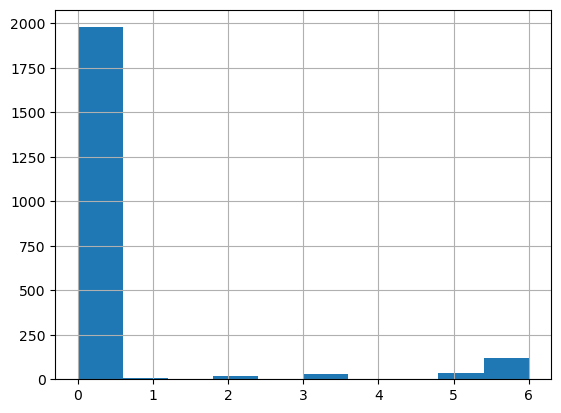

In [5]:
# Count the number of NaN values for each row in train_reduced.
train_physical['NaNs'] = train_physical.isna().sum(axis=1)

#Make a histogram of the distribution of these counts
train_physical['NaNs'].hist()

# Make a table of the distribution of train_reduced['NaNs']
print(train_physical['NaNs'].value_counts())

Before removing participants, we should look at their age distribution and see if it matches the overall age distribution.

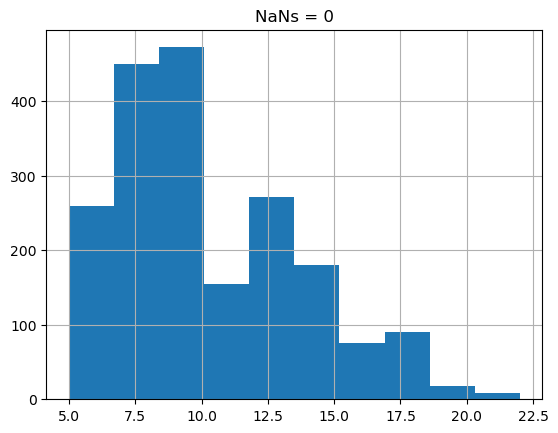

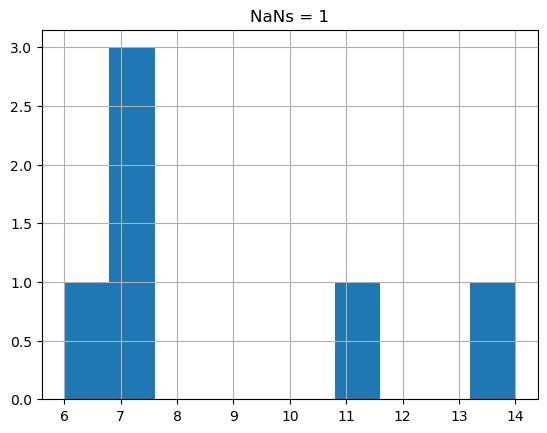

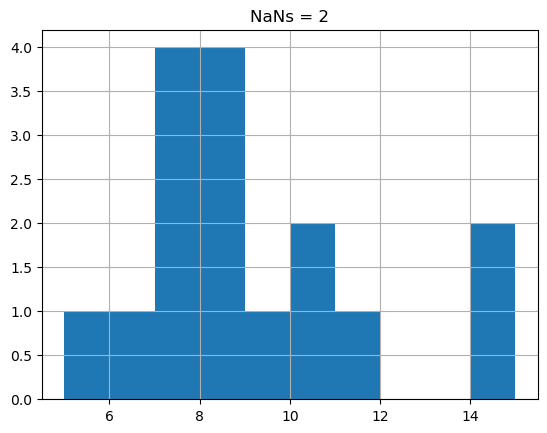

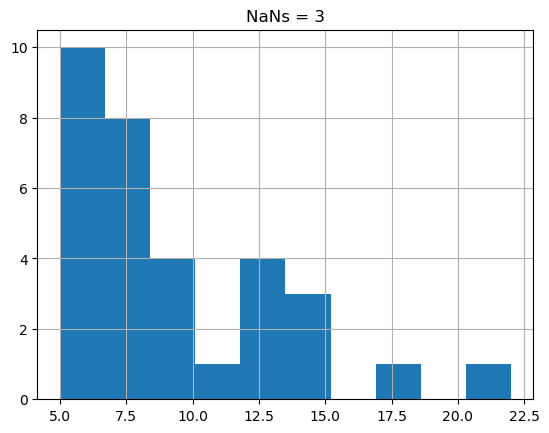

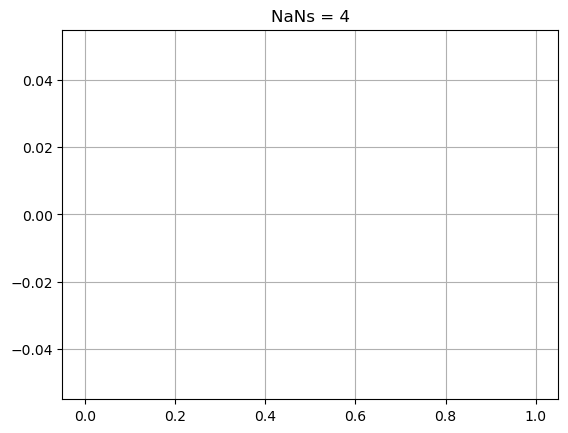

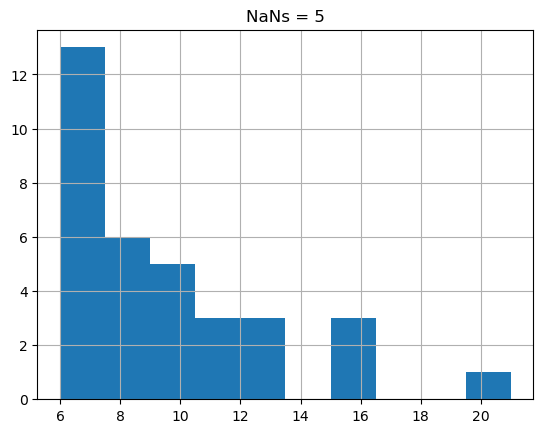

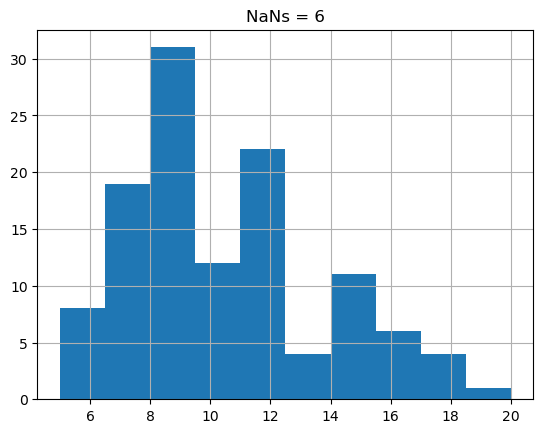

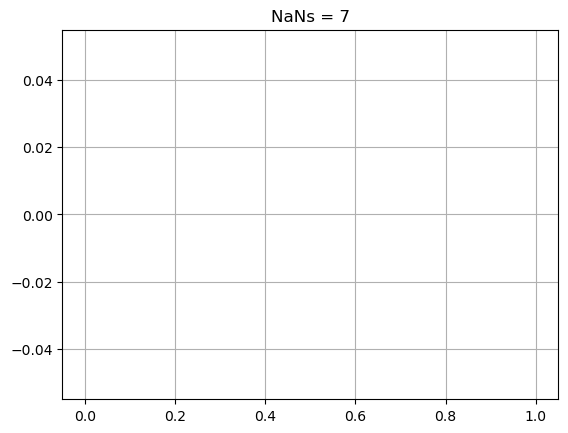

In [6]:
# Add the Basic_Demos-Age variable from the train data frame into the train_physical data frame
train_physical['Age'] = train['Basic_Demos-Age']

# Create a set of seven histograms of the values of Age for each value of train_physical['NaNs']
for i in range(8):
    train_physical[train_physical['NaNs'] == i]['Age'].hist()
    plt.title('NaNs = ' + str(i))
    plt.show()

<Axes: >

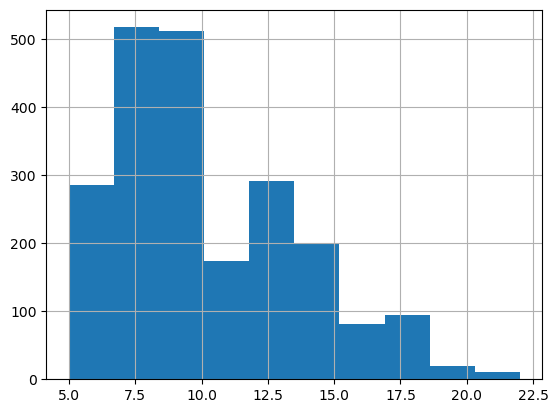

In [7]:
# Create a histogram of the distribution of Age
train_physical['Age'].hist()

It looks like the distribution of ages for each number of NaNs is roughly the same: Unimodal and skewed to the right, although the mode is at slightly different locations for each NaN value. But they're similar enough that I feel more confident about removing participants who have some missing values.

It looks like most of the NaN values are coming from participants with little or no Physical data: 118 participants didn't have any Physical values and another 34 only had one. 

This leaves 54 participants (out of the remaining 1978) who had 1, 2, or 3 missing values. 

There *are* PCA algorithms that try to estimate missing values. Here is an article about some options in R:
https://medium.com/@seb231/principal-component-analysis-with-missing-data-9e28f440ce93

It seems like the safest thing to do here is to remove all of these participants from the data set (for now) rather than trying to impute values, since the imputation would likely rely on the values we're trying to use to generate the PCA analysis.

In [8]:
# Remove the Age variable from train_physical
train_physical = train_physical.drop(columns=['Age'])

# Remove all rows that contain one or more NaN values from train_physical
train_physical = train_physical.dropna()

# Remove the NaNs variable from train_physical
train_physical = train_physical.drop(columns=['NaNs'])

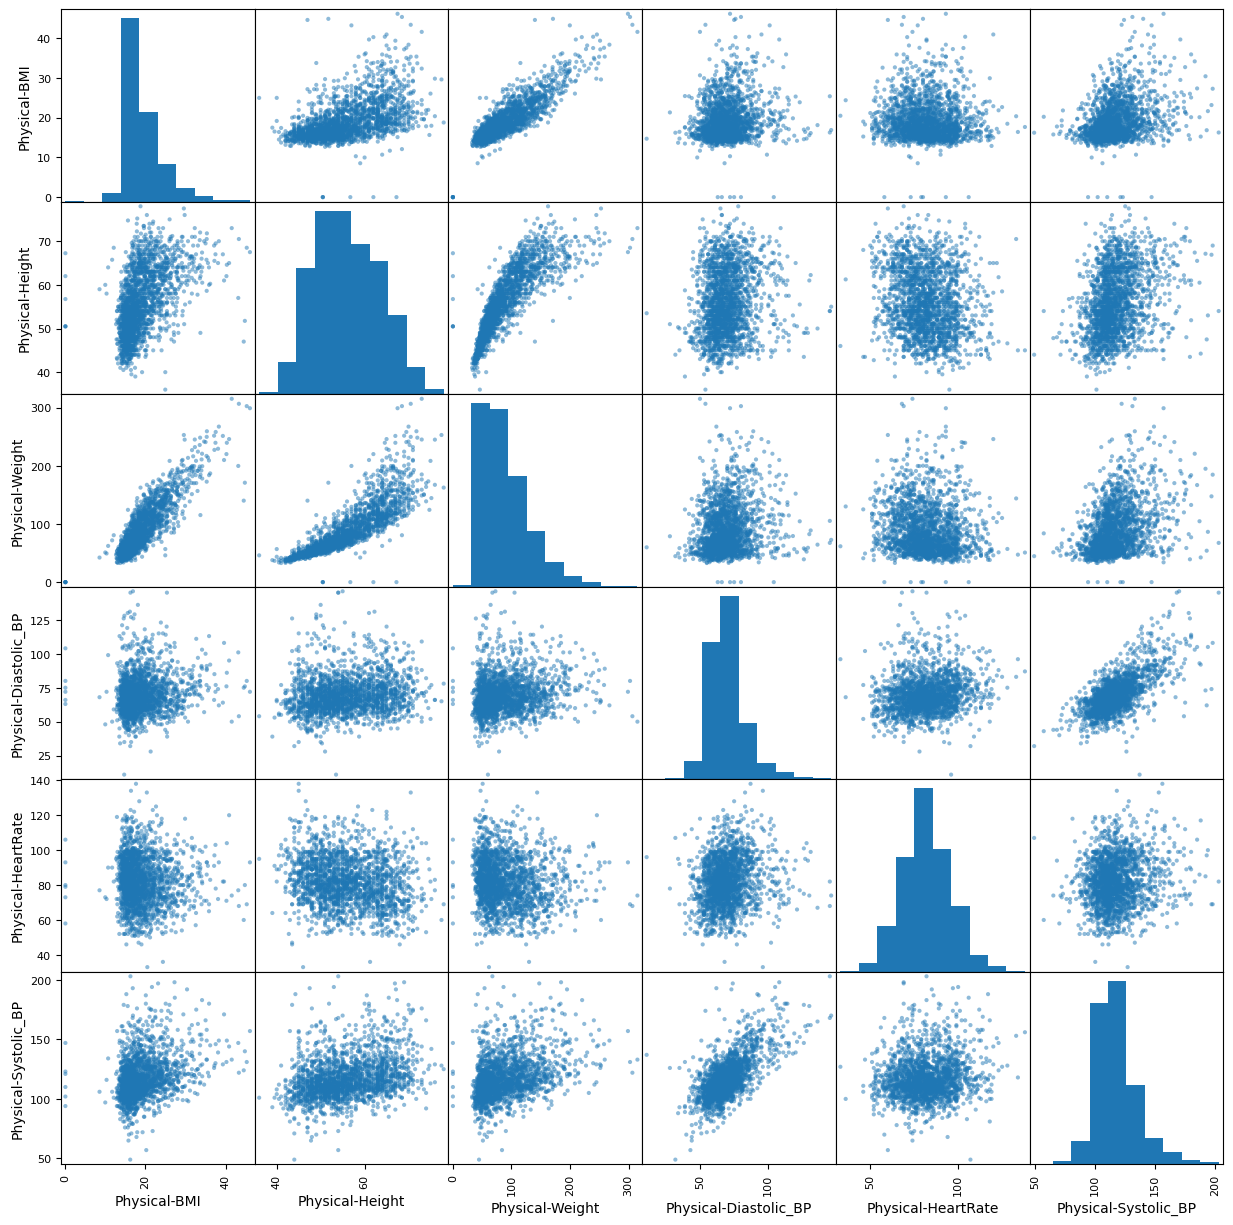

In [9]:
# PCA can only be used with linear data. So let's examine relationships between these five variables
from pandas.plotting import scatter_matrix
scatter_matrix(train_physical, figsize=(15,15))
plt.show()

**There are some clear linear associations here.**

The following variables appear to be linearly associated:
<ul>
<li>*BMI and Weight
<li>*Diastolic_BP and Systolic_BP
</ul>

When I looked at this previously, I found a couple of associations with Waist_Circumference (which we dropped from the data):
<ul>
<li>*BMI and Waist_Circumference
<li>*Height and Waist_Circumference
<li>*Weight and Waist_Circumference
<li>*Waist_Circumference and Systolic_BP
</ul>

The following variables appear to be associated in some non-linear way
<ul>
<li>*BMI and Height (as height increases, BMI increases... quadratically? exponentially?)
<li>*Height and Weight (as height increases, Weight increases... quadratically? exponentially?)
</ul>

We can also look at a correlation matrix between these variables

In [10]:
# Create a correlation matrix of the variables in physical_vars
train_physical.corr()

,Physical-BMI,Physical-Height,Physical-Weight,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP
Physical-BMI,1.000000,0.501320,0.875229,0.146883,-0.033187,0.325791
Physical-Height,0.501320,1.000000,0.834289,0.131355,-0.182951,0.311533
Physical-Weight,0.875229,0.834289,1.000000,0.153962,-0.110546,0.365724
Physical-Diastolic_BP,0.146883,0.131355,0.153962,1.000000,0.157856,0.674454
Physical-HeartRate,-0.033187,-0.182951,-0.110546,0.157856,1.000000,0.128591
Physical-Systolic_BP,0.325791,0.311533,0.365724,0.674454,0.128591,1.000000


Each column has at least one large-ish value, with the exception of HeartRate, so these data are a good candidate for PCA.

BUT! Some of the relationships are (slightly?) non-linear, so maybe we should be using Kernel PCA instead of regular PCA?

Just to get some practice, I'll proceed with regular PCA first. I'll be following the steps and explanation on https://medium.com/analytics-vidhya/dimensionality-reduction-principal-component-analysis-d1402b58feb1

In [11]:
# Instantiate a new PCA object
pca_physical = PCA()

# PCA requires data to be centered at 0, so we need to first scale the data
X_Scaled = StandardScaler().fit_transform(train_physical)

# Then we'll fit and transform the data
principalComponents_Physical = pca_physical.fit_transform(X_Scaled)

**Note**

If we want to apply this PCA transformation to a different data set, here we'd just call 'fit' on the data (after removing NaN values). Then, we'd later call 'transform' on the big data set that includes imputed values

In [12]:
# Examine the principal components
principalComponents_Physical = pd.DataFrame(principalComponents_Physical)
print(principalComponents_Physical.shape)
principalComponents_Physical.head(5)

(1978, 6)


,0,1,2,3,4,5
0,0.485194,0.942511,-0.839533,-0.576339,-0.025934,-0.096343
1,-1.611138,-0.981086,-0.488815,0.271603,-0.690417,0.022557
2,3.889578,-1.750536,-0.127250,-1.007233,-0.318160,0.254139
3,-0.481381,-1.389346,1.826290,0.008178,-0.648758,-0.128239
4,-1.489506,-0.726066,-0.984021,-0.216631,-0.005558,0.051038


We get 6 principal components (which is equal to the number of predictors). The first principal component (0) gives the direction of maximum variance.

The eigenvalues of the covariance matrix explain the maximum variance. The first eigenvalue explains maximum variance

In [13]:
# List the eigenvalues for the covariance matrix of train_reduced
pca_physical.explained_variance_

array([2.81532446, 1.51791301, 0.88283072, 0.47476528, 0.29718792,
       0.01501353])

Next, we can look at how much percentage of variance is explained by each principal component and the number of components we need to retain maximum variance from our original data.

In [14]:
# Compute pca.explained_variance_ratio_
pca_physical.explained_variance_ratio_

array([0.46898352, 0.2528576 , 0.14706407, 0.07908754, 0.04950628,
       0.00250099])

So:
<ul>
<li> The first principal component explains 47% of the variance
<li> The second principal component explains 25% of the variance
<li> The third principal component explains 15% of the variance
<li> The fourth principal component explains 8% of the variance
<li> The fifth principal component explains 5% of the variance
<li> The sixth principal component explains 0.3% of the variance
</ul>

This means that we could explain 72% of the total variance with the first two components, and 87% of the total variance with the first three.

So it seems like we can use three of these components rather than all six...?

Next, we need to understand which variables from the original data influenced these principal components the most.

In [15]:
# Create a data frame of the principal components
pc_df_physical = pd.DataFrame(abs(pca_physical.components_[:3]), columns=train_physical.columns, index=['Principal component 1','Principal component 2','Principal component 3'])

pc_df_physical

,Physical-BMI,Physical-Height,Physical-Weight,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP
Principal component 1,0.492905,0.481685,0.560056,0.258992,0.042434,0.377470
Principal component 2,0.168750,0.243935,0.235130,0.621496,0.462945,0.506120
Principal component 3,0.283944,0.045017,0.161554,0.326271,0.854674,0.233088


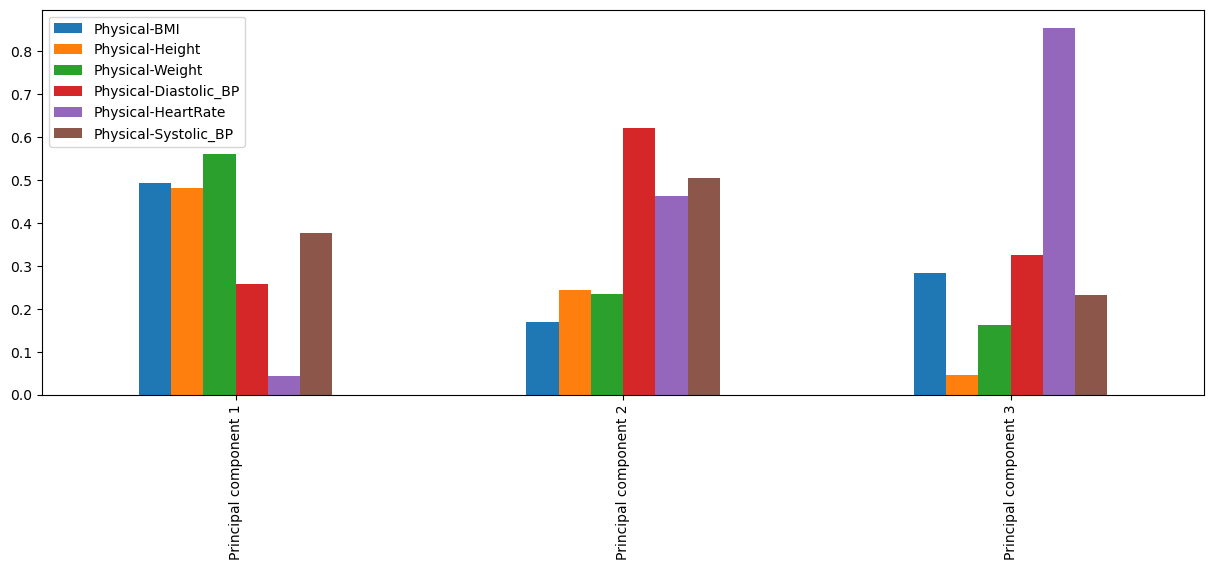

In [16]:
# Make a bargraph for each index in pc_df
pc_df_physical.plot(kind='bar', figsize=(15,5))
plt.show()

This graph suggests that there are three basic components:
<ul>
<li> How "big" you are (Height-weight-BMI)
<li> Your blood pressure (Diastolic & Systolic BP, and a bit of heart rate)
<li> Heart rate
</ul>

I'm going to try adding a couple of more complicated graphs. These will likely be more difficult to interpret.

KeyError: (slice(None, None, None), 0)

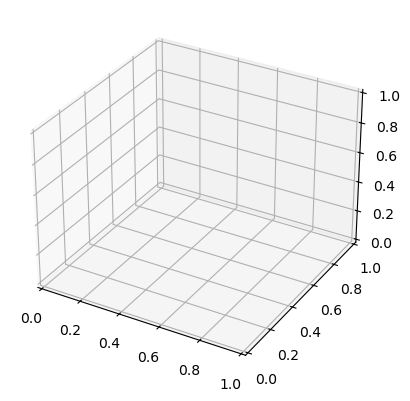

In [17]:
# Make a 3D graph
# This syntax suggested by the AI in my Brave search engine... :)

# Prepare 3D plotting environment
fig = plt.figure()
ax = plt.axes(projection='3d')

# Plot 3D PCA scatterplot
xdata = principalComponents_Physical[:, 0]
ydata = principalComponents_Physical[:, 1]
zdata = principalComponents_Physical[:, 2]
ax.scatter3D(xdata, ydata, zdata, c=zdata, cmap='viridis')

# Customize plot
plt.title('3D Scatter of Physical Components')
ticks = np.linspace(-3, 3, num=5)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_zticks(ticks)
ax.set_xlabel('Component 0?', rotation=150)
ax.set_ylabel('Component 1?')
ax.set_zlabel('Component 2?', rotation=60)
plt.show()


In [20]:
# Visualize the loadings
# (From https://plotly.com/python/pca-visualization/)

import plotly.express as px

#df = px.data.iris()
#features = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
#X = df[features]

#pca = PCA(n_components=2)
#principalComponents = pca.fit_transform(X)

loadings = pca_physical.components_.T * np.sqrt(pca_physical.explained_variance_)

fig = px.scatter(principalComponents_Physical, x=0, y=1)

for i, feature in enumerate(train_physical.columns):
    fig.add_annotation(
        ax=0, ay=0,
        axref="x", ayref="y",
        x=loadings[i, 0],
        y=loadings[i, 1],
        showarrow=True,
        arrowsize=2,
        arrowhead=2,
        xanchor="right",
        yanchor="top"
    )
    fig.add_annotation(
        x=loadings[i, 0],
        y=loadings[i, 1],
        ax=0, ay=0,
        xanchor="center",
        yanchor="bottom",
        text=feature,
        yshift=5,
    )
fig.show()

Next, let's look at the FitnessGram quantitative variables:

* FGC-FGC_CU
* FGC-FGC_GSND
* FGC-FGC_GSD
* FGC-FGC_PU
* FGC-FGC_SRL
* FGC-FGC_SRR
* FGC-FGC_TL

The other FitnessGram variables are categorical; it seems like we could scale and sum them to get a single overall measure of fitness?

There are also the 
* Fitness_Endurance-Max_Stage
* Fitness_Endurance-Time_Mins
* Fitness_Endurance-Time_Sec

The FitnessGram scores get mapped to "Healthy Fitness Zones" https://www.topendsports.com/testing/fitnessgram.htm

The cutoffs are found here: https://pftdata.org/files/hfz-standards.pdf

Several variables are also classified as being in a healthy zone (1) or not (0). We could create a new variable by adding:
* FGC-FGC_CU_Zone
* FGC-FGC_PU_Zone
* FGC-FGC_SRL_Zone
* FGC-FGC_SRR_Zone
* FGC-FGC_TL_Zone


Note that the grip strength categories are also classified, but as weak (0), normal (1), and strong (2). Luckily (see below) we're not going to include grip strength as a predictor, so we don't have to worry about this different scale.

In [26]:
# Create a new variable by converting Fitness_Endurance-Time_Mins from minutes to seconds and then adding it to Fitness_Endurance-Time_Sec
train['Fitness_Endurance-Total_Time_Sec'] = train['Fitness_Endurance-Time_Mins'] * 60 + train['Fitness_Endurance-Time_Sec']

In [27]:
# Create a new variable FGC_Zone_Total that is the sum of FGC-FGC_CU_Zone, FGC-FGC_PU_Zone, FGC-FGC_SRL_Zone, FGC-FGC_SRR_Zone, FGC-FGC_TL_Zone
train['FGC_Zone_Total'] = train['FGC-FGC_CU_Zone'] + train['FGC-FGC_PU_Zone'] + train['FGC-FGC_SRL_Zone'] + train['FGC-FGC_SRR_Zone'] + train['FGC-FGC_TL_Zone']

In [28]:
# We'll next explore the "FitnessGram" variables. 
# One variable is "Season of Participation" which we'll exclude from this PCA

# Make a list of all variables that start with 'Physical' and are type float or int
fitness_vars = ['FGC-FGC_CU','FGC-FGC_GSND','FGC-FGC_GSD','FGC-FGC_PU','FGC-FGC_SRL','FGC-FGC_SRR','FGC-FGC_TL', 'FGC_Zone_Total', 'Fitness_Endurance-Total_Time_Sec', 'Fitness_Endurance-Max_Stage']

train_fitness = train[fitness_vars]

In [29]:
# Count the number of NaN values for each variable
print(train_fitness.isna().sum())

FGC-FGC_CU                           654
FGC-FGC_GSND                        1487
FGC-FGC_GSD                         1488
FGC-FGC_PU                           661
FGC-FGC_SRL                          660
FGC-FGC_SRR                          659
FGC-FGC_TL                           654
FGC_Zone_Total                       693
Fitness_Endurance-Total_Time_Sec    1601
Fitness_Endurance-Max_Stage         1597
dtype: int64


It looks like grip strength and endurance weren't't computed for a *lot* of participants, so maybe we'll drop these variables?

In [30]:
# Remove the 'FGC-FGC_GSND' and 'FGC-FGC_GSD' variables from train_fitness
train_fitness = train_fitness.drop(columns=['FGC-FGC_GSND','FGC-FGC_GSD'])

# Remove the Fitness-Endurance-Total_Time_Sec and Fitness_Endurance-Max_Stage variables from train_fitness
train_fitness = train_fitness.drop(columns=['Fitness_Endurance-Total_Time_Sec','Fitness_Endurance-Max_Stage'])

<Axes: >

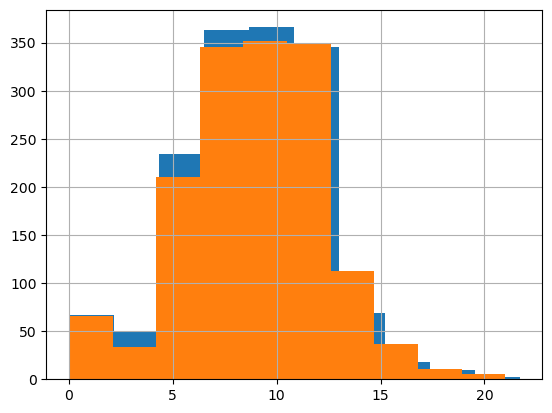

In [31]:
# The SRL and SRR have a few 0 scores, which seems surprising.

# Make a histogram of FGC-FGC_SRL
train_fitness['FGC-FGC_SRL'].hist()
train_fitness['FGC-FGC_SRR'].hist()

The 0 values seem suspicious. It seems like the distribution should be roughly normal.

Reading more about the sit & reach protocol used in the FitnessGram assessment: https://www.topendsports.com/testing/tests/sit-and-reach-backsaver.htm and watching a video of the protocol: https://www.youtube.com/watch?v=sFi_RgN1kGs

It looks like students who can't reach the end of the ruler are scored as a 0. Some of these scores should be negative (i.e., how far they are from the end of the ruler), but there is a floor effect. So the 0 scores arn't NaNs, although they're affected by the floor effect.

There isn't any way to adjust these scores reliably, so I'm going to keep them in for now.

NaNs
0    1490
6     653
1      28
2       6
3       5
4       2
Name: count, dtype: int64


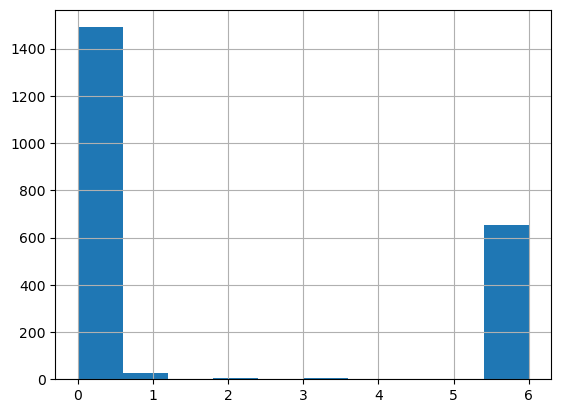

In [32]:
# Count the number of NaN values for each row in train_fitness.
train_fitness['NaNs'] = train_fitness.isna().sum(axis=1)

#Make a histogram of the distribution of these counts
train_fitness['NaNs'].hist()

# Make a table of the distribution of train_reduced['NaNs']
print(train_fitness['NaNs'].value_counts())

Again, it looks like most of the NaNs are coming from the same set of participants who didn't have any data.

**We should see if these are the same people who didn't have data for the physical variables**

**We should also check the age distribution of these participants**

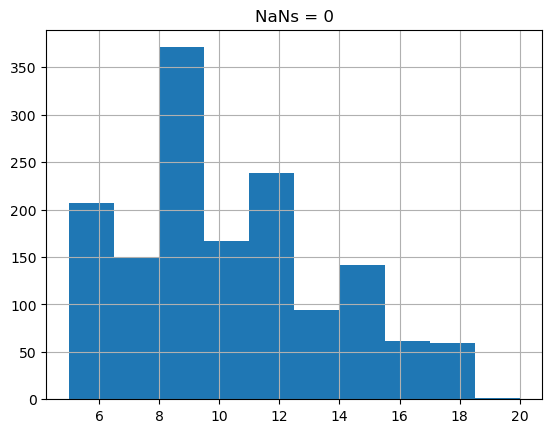

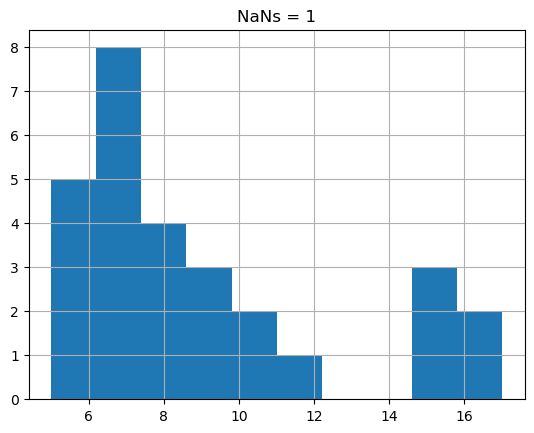

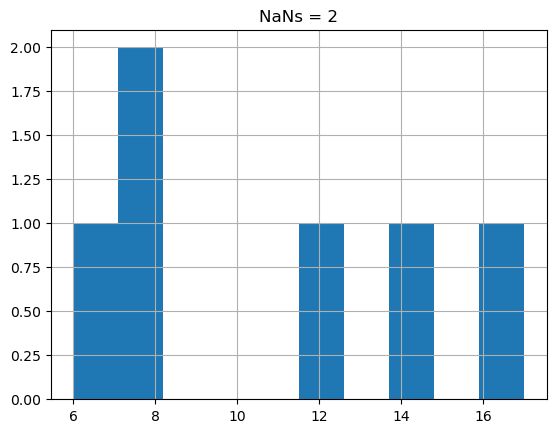

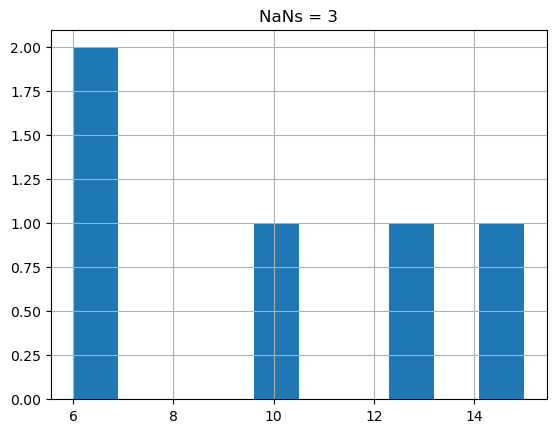

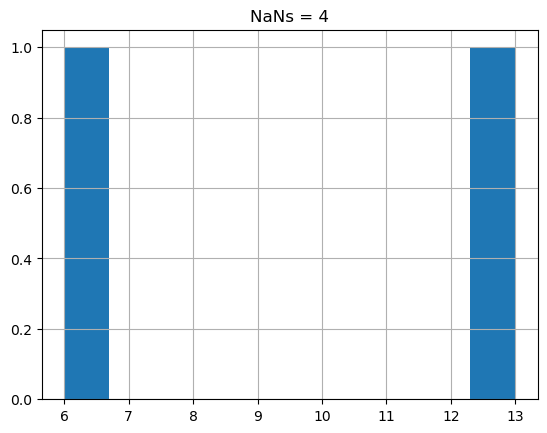

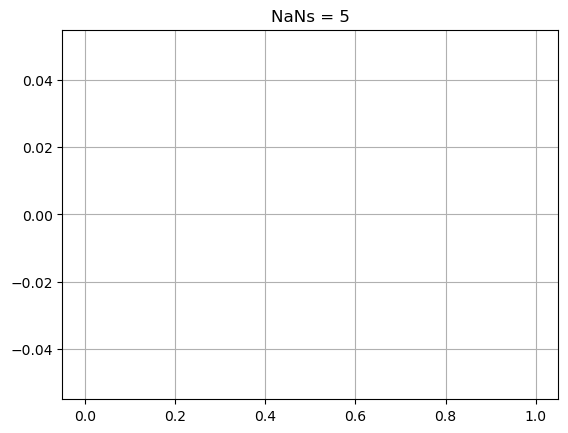

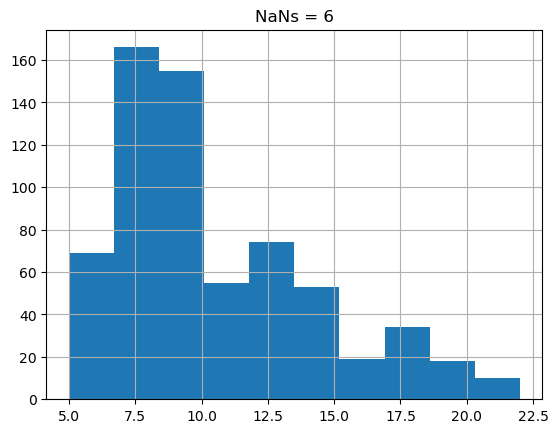

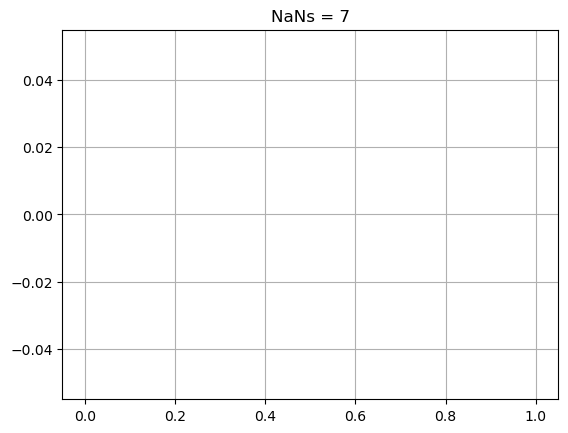

In [33]:
# Add the 'Basic_Demos-Age' variable from the train data frame to the train_fitness data frame
train_fitness['Age'] = train['Basic_Demos-Age']

# Make a histogram of the Age variable for each level of the NaNs variable
for i in range(8):
    train_fitness[train_fitness['NaNs'] == i]['Age'].hist()
    plt.title('NaNs = ' + str(i))
    plt.show()

The distribution of age for each number of NaNs appears to be the roughly the same (unimodal, skewed right, mode around 7.5-8). So dropping participants with NaNs shouldn't have any interaction with age.

In [34]:
# Remove the Age variable from train_fitness
train_fitness = train_fitness.drop(columns=['Age'])

# Remove all rows that contain one or more NaN values from train_fitness
train_fitness = train_fitness.dropna()

# Remove the NaNs variable from train_fitness
train_fitness = train_fitness.drop(columns=['NaNs'])

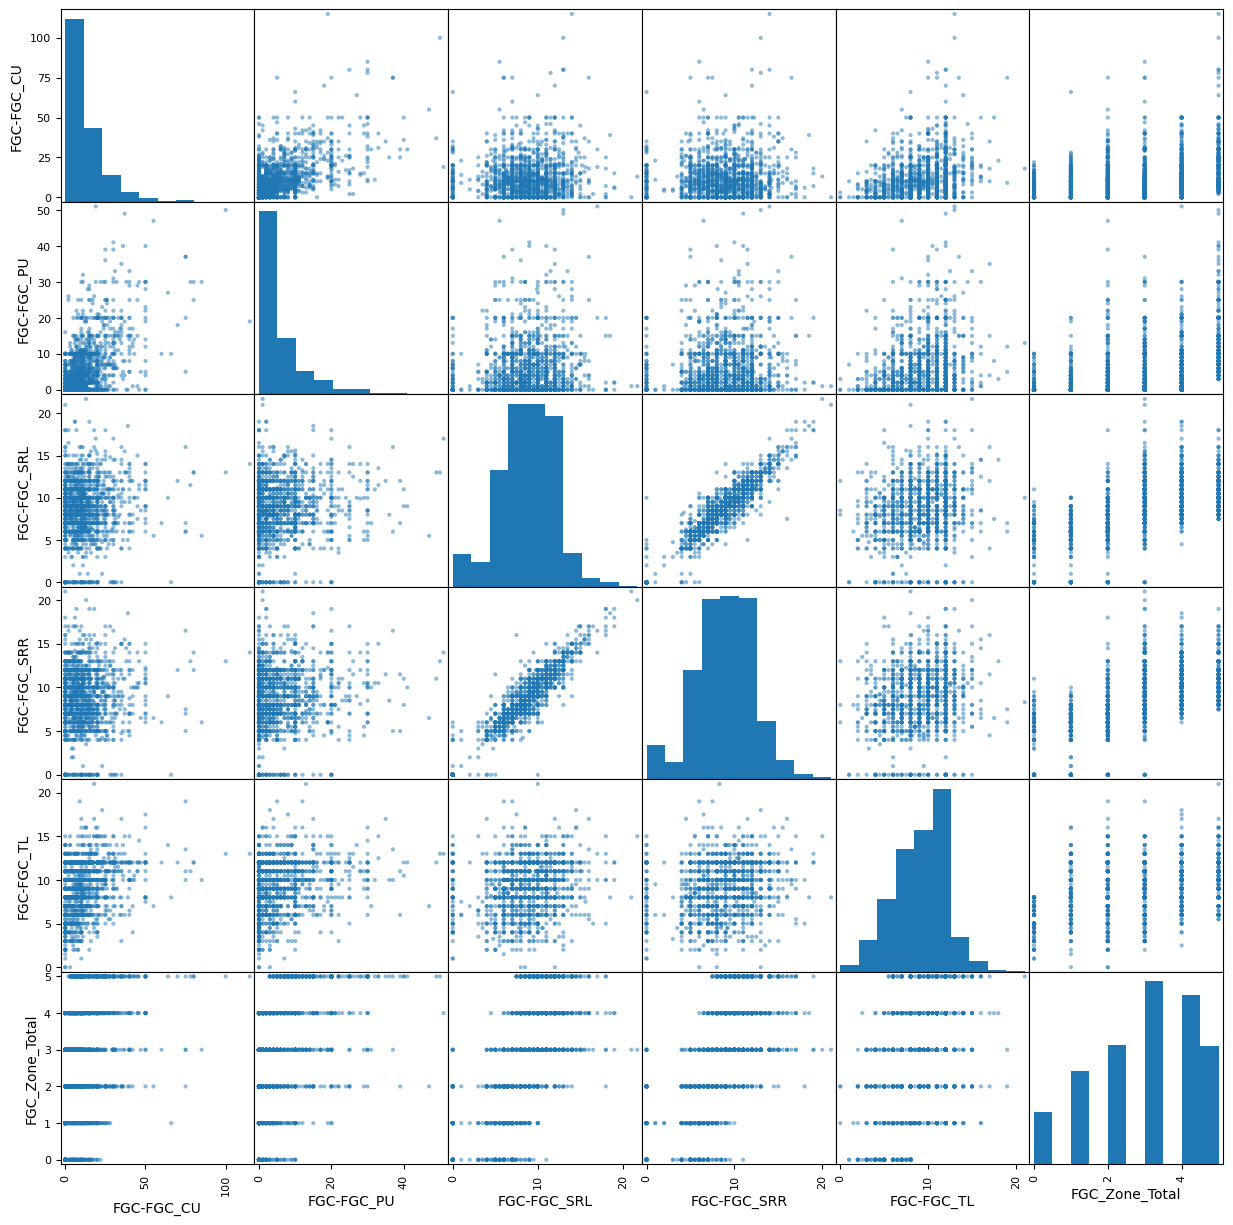

,FGC-FGC_CU,FGC-FGC_PU,FGC-FGC_SRL,FGC-FGC_SRR,FGC-FGC_TL,FGC_Zone_Total
FGC-FGC_CU,1.000000,0.575865,0.059328,0.045652,0.299923,0.281783
FGC-FGC_PU,0.575865,1.000000,0.098718,0.093712,0.238231,0.399919
FGC-FGC_SRL,0.059328,0.098718,1.000000,0.918786,0.207908,0.618804
FGC-FGC_SRR,0.045652,0.093712,0.918786,1.000000,0.204702,0.635801
FGC-FGC_TL,0.299923,0.238231,0.207908,0.204702,1.000000,0.393918
FGC_Zone_Total,0.281783,0.399919,0.618804,0.635801,0.393918,1.000000


In [35]:
# PCA can only be used with linear data. So let's examine relationships between these five variables
scatter_matrix(train_fitness, figsize=(15,15))
plt.show()

# Create a correlation matrix of the variables in physical_vars
train_fitness.corr()

There is a strong correlation between the two sit & reach variables. The others have at most weak associations, although none look nonlinear.

HOWEVER, there appear to be some values at 0, which seems odd

In [36]:
# Instantiate a new PCA object
pca_fitness = PCA()

# PCA requires data to be centered at 0, so we need to first scale the data
X_Scaled_Fitness = StandardScaler().fit_transform(train_fitness)

# Then we'll fit and transform the data
principalComponents_Fitness = pca_fitness.fit_transform(X_Scaled_Fitness)


In [37]:
# Examine the principal components
principalComponents_Fitness = pd.DataFrame(principalComponents_Fitness)
print(principalComponents_Fitness.shape)
principalComponents_Fitness.head(5)

(1490, 6)


,0,1,2,3,4,5
0,-1.747257,-0.209432,-0.348205,1.260218,-0.751921,-0.056819
1,-2.469594,-0.487687,-0.270060,-0.120318,-0.120852,-0.219847
2,-0.386459,0.453789,0.195676,0.013560,0.354485,0.079865
3,-0.697944,-0.917745,-0.246158,-0.125271,0.457492,-0.254649
4,0.977664,1.906201,0.129715,-0.957897,-0.201825,0.187272


In [38]:
# Compute pca.explained_variance_ratio_
pca_fitness.explained_variance_ratio_

array([0.46535217, 0.26431044, 0.13025183, 0.07509757, 0.05156522,
       0.01342278])

The first three components will explain approximately 87% of the variation. So we can probably just focus on those and drop three of the predictors.

In [39]:
# Create a data frame of the principal components
pc_df_fitness = pd.DataFrame(abs(pca_fitness.components_[:3]), columns=train_fitness.columns, index=['Principal component 1','Principal component 2','Principal component 3'])

pc_df_fitness

,FGC-FGC_CU,FGC-FGC_PU,FGC-FGC_SRL,FGC-FGC_SRR,FGC-FGC_TL,FGC_Zone_Total
Principal component 1,0.255796,0.291795,0.492165,0.493219,0.308929,0.518165
Principal component 2,0.587515,0.544584,0.382292,0.390058,0.244733,0.008223
Principal component 3,0.186053,0.371034,0.120927,0.118834,0.893843,0.004148


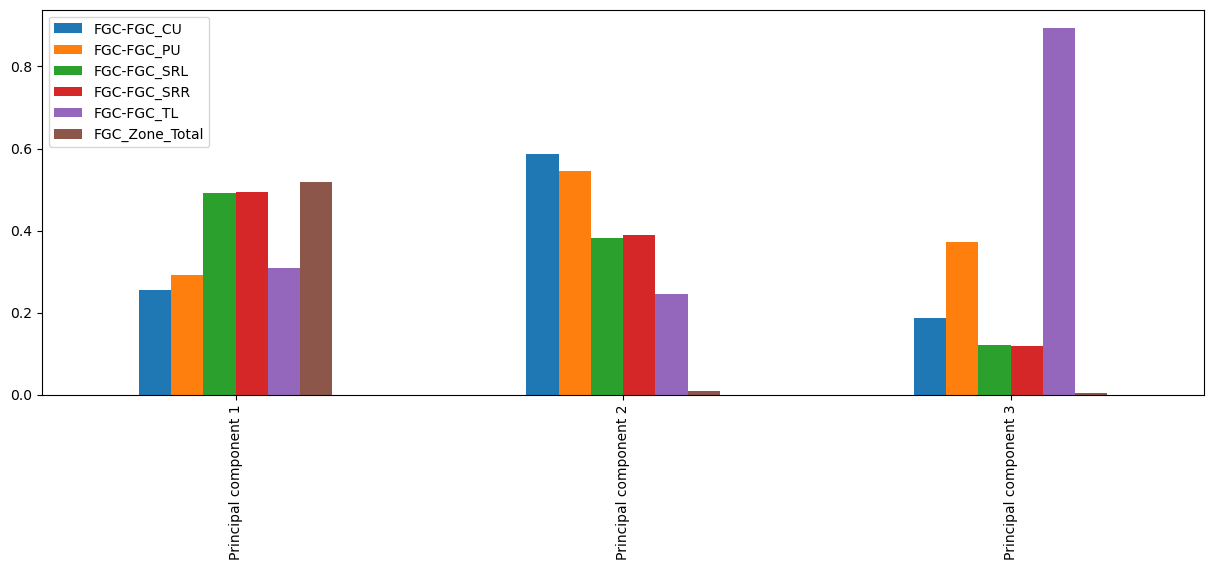

In [40]:
# Make a bargraph for each index in pc_df
pc_df_fitness.plot(kind='bar', figsize=(15,5))
plt.show()

It looks like:

* The first principal component is the sit & reach test (left and right) and the sum of the Healthy Zone scores
* The second component is primarily the curl-up and push-up totals, with a bit of the sit & reach
* The third component is trunk lift total and a little bit of the push ups.

Finally, let's look at the bio-electric impedance variables Two of these are categorical (Activity Level and Body Frame), and we'll likely use those as alternative predictors. The rest are all floats:

* BIA-BIA_BMC
* BIA-BIA_BMI
* BIA-BIA_BMR
* BIA-BIA_DEE
* BIA-BIA_ECW
* BIA-BIA_FFM
* BIA-BIA_FFMI
* BIA-BIA_FMI
* BIA-BIA_Fat
* BIA-BIA_ICW
* BIA-BIA_LDM
* BIA-BIA_LST
* BIA-BIA_SMM
* BIA-BIA_TBW

In [47]:
# In a previous exploration, we identified id=e252dcb6 as having outlier bia values. This should be addressed through cleaning, but for the purpose of exploration, we'll just remove this person from train

# Remove id=e252dcb6 from train
#train = train[train['id'] != 'e252dcb6']

# Create a new data set from train called train_bia that includes all variables that start with BIA-BIA_
train_bia = train[[col for col in train.columns if col.startswith('BIA-BIA_')]]

# Remove the variables BIA-BIA_Activity_Level_num and BIA-BIA_Frame_num from train_bia
train_bia = train_bia.drop(columns=['BIA-BIA_Activity_Level_num','BIA-BIA_Frame_num'])

In [35]:
# Count the number of NaN values for each variable
print(train_bia.isna().sum())

BIA-BIA_BMC     747
BIA-BIA_BMI     733
BIA-BIA_BMR     733
BIA-BIA_DEE     733
BIA-BIA_ECW     733
BIA-BIA_FFM     733
BIA-BIA_FFMI    733
BIA-BIA_FMI     749
BIA-BIA_Fat     749
BIA-BIA_ICW     733
BIA-BIA_LDM     733
BIA-BIA_LST     733
BIA-BIA_SMM     733
BIA-BIA_TBW     733
dtype: int64


Next, we'll see whether the NaNs are all coming from the same individuals

NaNs
0     1434
14     733
3       14
2        2
Name: count, dtype: int64


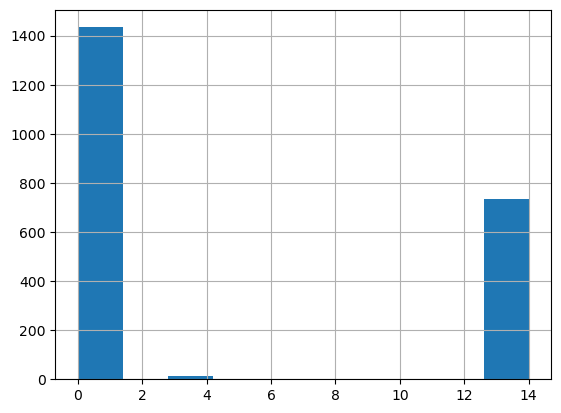

In [36]:
# Count the number of NaN values for each row in train_bia.
train_bia['NaNs'] = train_bia.isna().sum(axis=1)

#Make a histogram of the distribution of these counts
train_bia['NaNs'].hist()

# Make a table of the distribution of train_reduced['NaNs']
print(train_bia['NaNs'].value_counts())

Yup - nearly all of the missing values are from the same individuals. We should check the age distribution of these missing values to make sure there isn't any interaction

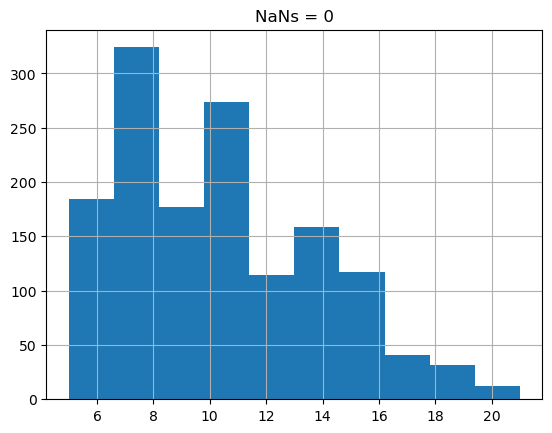

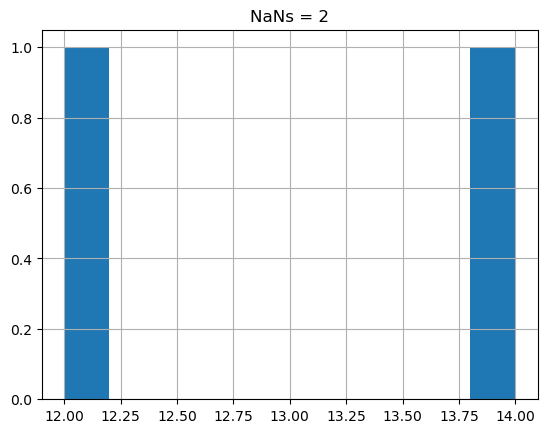

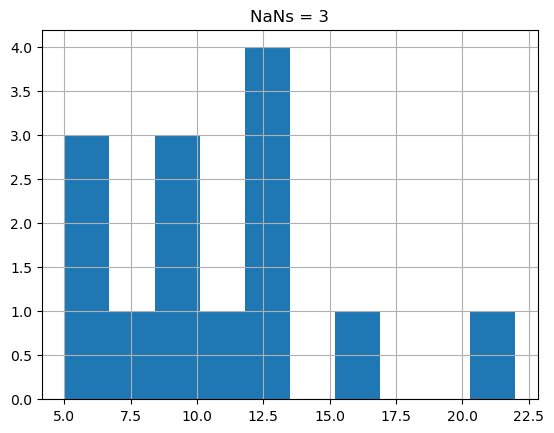

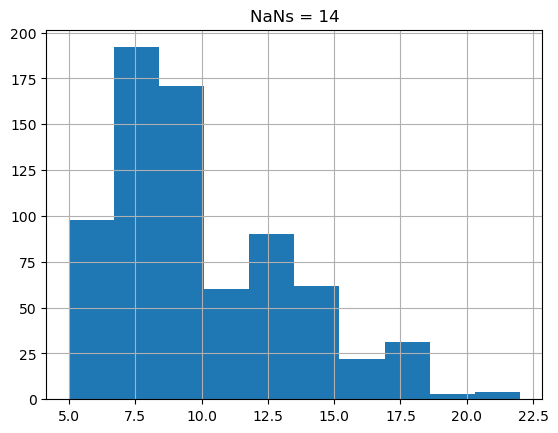

In [37]:
# Add the 'Basic_Demos-Age' variable from the train data frame to the train_bia data frame
train_bia['Age'] = train['Basic_Demos-Age']

# Create a set of the numbers 0, 2, 3, and 14
nums = [0, 2, 3, 14]

# Make a histogram of the Age variable for each level of the NaNs variable
for i in nums:
    train_bia[train_bia['NaNs'] == i]['Age'].hist()
    plt.title('NaNs = ' + str(i))
    plt.show()


Distributions all look basically the same, so we'll drop individuals with NaNs

In [38]:
# Remove the Age variable from train_bia
train_bia = train_bia.drop(columns=['Age'])

# Remove all rows that contain one or more NaN values from train_bia
train_bia = train_bia.dropna()

# Remove the NaNs variable from train_bia
train_bia = train_bia.drop(columns=['NaNs'])

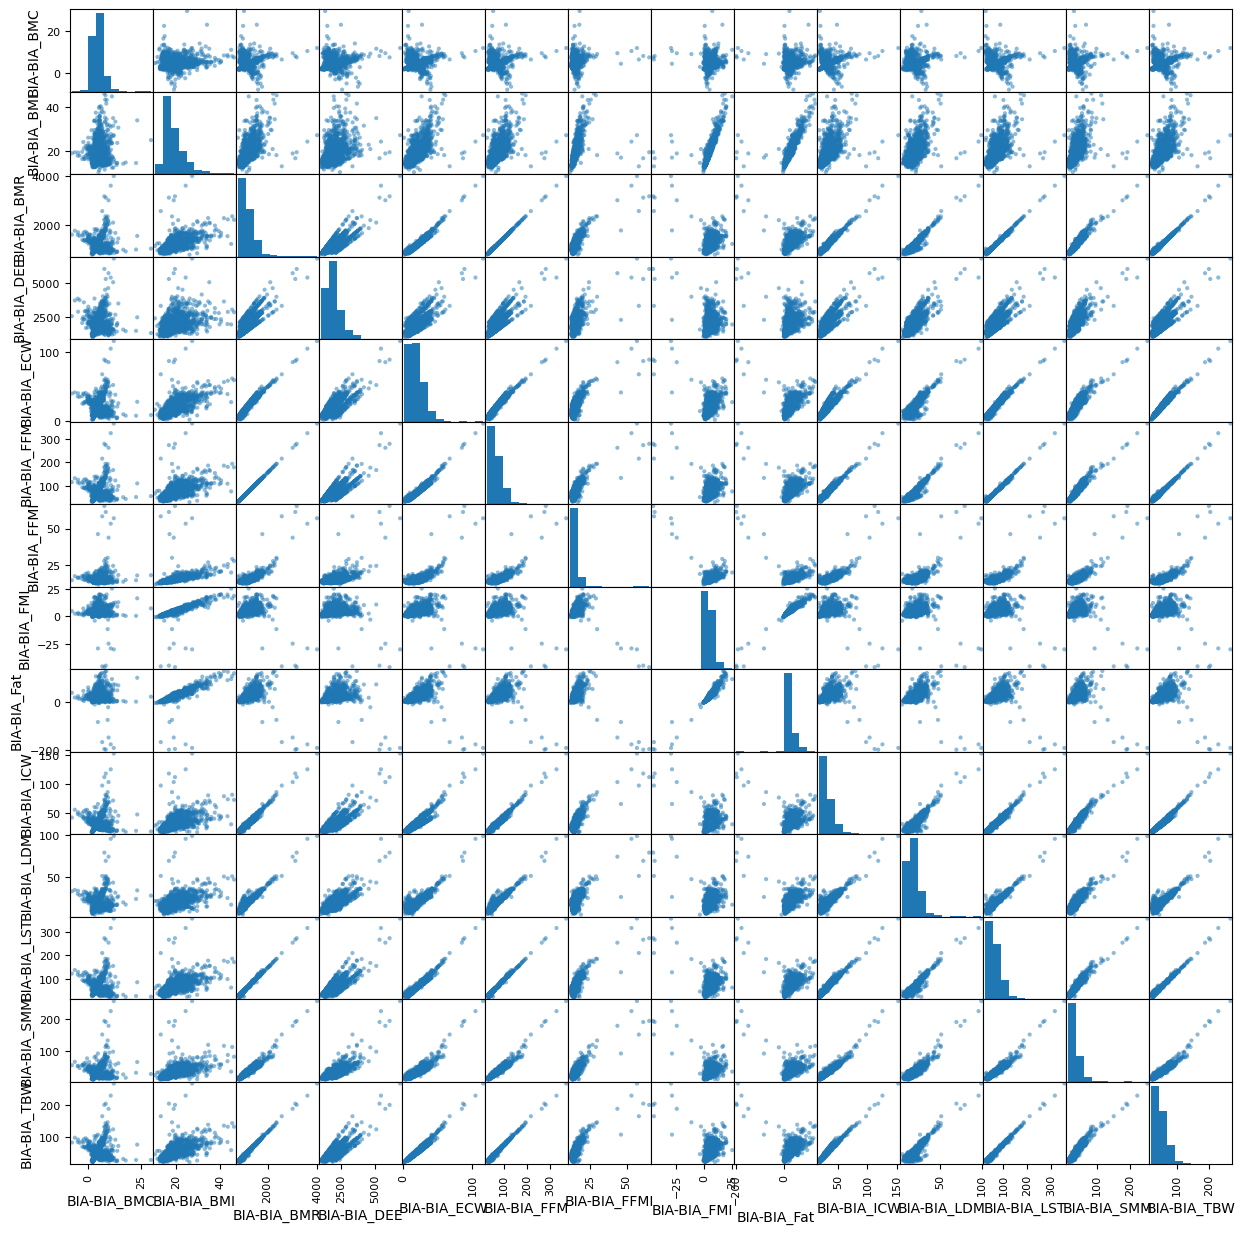

,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW
BIA-BIA_BMC,1.000000,0.240912,0.257640,0.235913,0.220842,0.257640,0.225699,0.087545,0.124986,0.246307,0.296372,0.174800,0.245652,0.238664
BIA-BIA_BMI,0.240912,1.000000,0.617325,0.427106,0.655395,0.617325,0.486512,0.720717,0.772097,0.572610,0.559759,0.607920,0.540997,0.626501
BIA-BIA_BMR,0.257640,0.617325,1.000000,0.835421,0.972926,1.000000,0.793466,0.053635,0.231841,0.975811,0.961432,0.996400,0.959459,0.994993
BIA-BIA_DEE,0.235913,0.427106,0.835421,1.000000,0.786126,0.835421,0.623838,-0.022296,0.123211,0.842586,0.801349,0.830600,0.809721,0.831911
BIA-BIA_ECW,0.220842,0.655395,0.972926,0.786126,1.000000,0.972926,0.748530,0.131424,0.305324,0.918003,0.905829,0.972040,0.909300,0.978801
BIA-BIA_FFM,0.257640,0.617325,1.000000,0.835421,0.972926,1.000000,0.793467,0.053635,0.231841,0.975811,0.961432,0.996400,0.959459,0.994993
BIA-BIA_FFMI,0.225699,0.486512,0.793466,0.623838,0.748530,0.793467,1.000000,-0.255019,-0.127898,0.820662,0.729510,0.788744,0.855999,0.801614
BIA-BIA_FMI,0.087545,0.720717,0.053635,-0.022296,0.131424,0.053635,-0.255019,1.000000,0.955998,-0.017431,0.040672,0.046974,-0.080459,0.057326
BIA-BIA_Fat,0.124986,0.772097,0.231841,0.123211,0.305324,0.231841,-0.127898,0.955998,1.000000,0.151542,0.218278,0.225281,0.080778,0.232360
BIA-BIA_ICW,0.246307,0.572610,0.975811,0.842586,0.918003,0.975811,0.820662,-0.017431,0.151542,1.000000,0.913848,0.972746,0.961054,0.979766


In [39]:
# PCA can only be used with linear data. So let's examine relationships between these five variables
scatter_matrix(train_bia, figsize=(15,15))
plt.show()

# Create a correlation matrix of the variables in physical_vars
train_bia.corr()


There are LOTS of strong correlations here. Nothing looks particularly nonlinear. BUT some of the variables appear to have some outliers. We should look into this

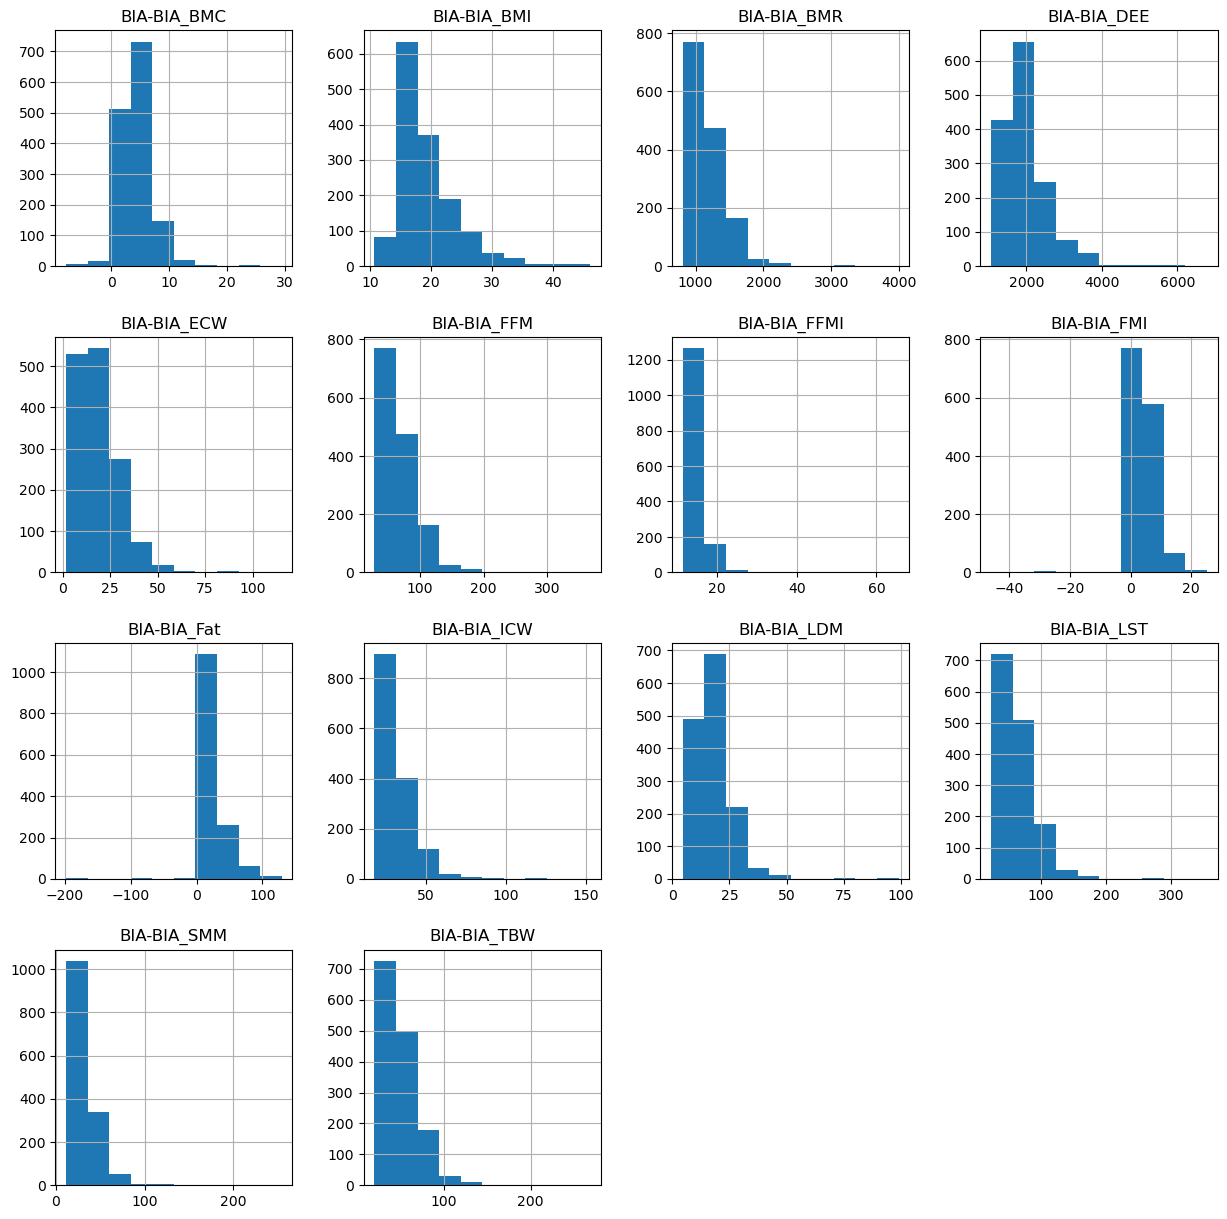

In [48]:
# Make a histogram for each variable in train_bia
train_bia.hist(figsize=(15,15))
plt.show()

It looks like this individual has bogus data...